In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

/home/taiger/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import datagen
import utils
from model import RPN

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
np.random.seed(1)
tf.set_random_seed(1)

(array([9, 9]),
 array([[108.48430493, 156.69955157, 123.55156951, 189.84753363],
        [157.70403587, 130.58295964, 189.84753363, 162.7264574 ],
        [ -1.0044843 ,  -1.0044843 ,  -2.00896861,  -2.00896861],
        [ -1.0044843 ,  -1.0044843 ,  -2.00896861,  -2.00896861]]))

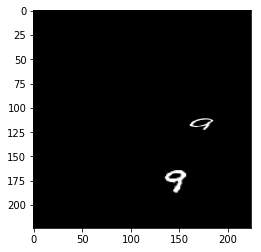

In [4]:
images, gt_cls, gt_boxes = datagen.generate_batch(32)

image = np.squeeze(images[0], axis=-1)
plt.imshow(image, cmap='gray')
gt_cls[0], gt_boxes[0] * 224

In [5]:
tf.reset_default_graph()
model = RPN()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    anchors, labels, mappings, loss = sess.run([model.anchors, model.labels, model.mappings, model.loss], feed_dict={
        model.images: images,
        model.gt_boxes: gt_boxes
    })
anchors.shape, labels.shape, mappings.shape

((6000, 4), (6000,), (6000,))

In [6]:
loss

0.69337624

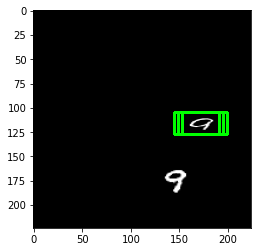

In [7]:
out = cv2.merge([(image * 255).astype(np.uint8)] * 3)
for idx in np.where(labels == 1)[0]:
    y1, x1, y2, x2 = map(int, anchors[idx])
    gt_box = mappings[idx]
    color = [(0, 255, 0), (255, 0, 0)][gt_box]
    cv2.rectangle(out, (x1, y1), (x2, y2), color, 2)
plt.imshow(out);

In [9]:
np.where(labels == 1)

(array([292, 477, 872]),)

In [10]:
np.unique(labels, return_counts=True)

(array([-1.,  0.,  1.], dtype=float32), array([5418,  579,    3]))